# Regresia logistică binomială
Sîrbu Matei-Dan, _grupa 10LF383_

# Load and preprocess data

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Tuple, List

In [4]:
def load_file(path: str) -> Tuple[np.ndarray, np.ndarray]:
    """Loads the data from the file stored at :param path: and returns the 
    input values and the class labels.
    :param path: path of a CVS file with data
    :return: a tuple containing the input matrix of shape (m, n) and a column 
    vector with the m class labels in {0, ..., 9}
    """
    # scrieti cod pentru citire de CSV
    df = pd.read_csv(path, header=None)
    X = df[df.columns[1:]]
    y = df[df.columns[0]].to_frame()
    assert X.ndim ==  2, 'Matrix required for input values'
    assert y.ndim == 2, 'Column matrix required for labels'
    assert y.shape == (X.shape[0], 1), 'Same number of lines is required'
    return X, y

In [5]:
path_train = './data/mnist_train.csv'
path_test = './data/mnist_test.csv'

In [6]:
X_train, y_train = load_file(path_train)
assert X_train.shape == (60000, 784)
assert y_train.shape == (60000, 1)

X_test, y_test = load_file(path_test)
assert X_test.shape == (10000, 784)
assert y_test.shape == (10000, 1)

In [7]:
def scale_values(X: np.ndarray) -> np.ndarray:
    """Scales the values to range [0, 1].
    :param X: an (m, n) matrix with values between 0 and 255.
    :return: an (m, n) matrix containing values of :param X: scaled in [0, 1]
    """
    # scrieti cod pentru scalare intre 0 si 1
    result = np.array(X) / 255
    assert 0 <= np.min(result) <= np.max(result) <= 1, 'Scaled values should be in [0, 1]'
    assert X.shape == result.shape, 'Scaling preserves shape'
    return result

In [8]:
X_train = scale_values(X_train)
assert X_train.shape == (60000, 784)

In [9]:
X_test = scale_values(X_test)
assert X_test.shape == (10000, 784)

In [10]:
digit1, digit2 = 3, 6 # alegeti 2 cifre

In [11]:
def filter_digits(X: np.ndarray, y: np.ndarray, digit1: int, digit2: int) -> Tuple[np.ndarray, np.ndarray]:
    """Returns the cases of class digit1 and digit2
    :param X: an (m, n) ndarray; each row is a digit
    :param y: an (m,1) vector; y[i, 0] is the class of digit i
    :param digit1: the first class to be selected
    :param digit2: the second class to be selected
    :return: a tuple of: (m', n) ndarray containing the rows with digits of 
    class digit1, digit2, and a (m', 1) ndarray with values digit1, digit2 
    """
    assert X.shape[0] == y.shape[0], 'X and y should have the same number of rows'
    assert y.shape[1] == 1, 'y should be column matrix'
    assert 0 <= min(digit1, digit2) < max(digit1, digit2) <= 9, 'there should be two different digits'
    # cod vectorizat pentru a selecta in result doar acele linii de clasa digit1, digit2
    rows_idx = np.where(np.logical_or(y==digit1,y==digit2))[0]
    result_X = X[rows_idx]
    result_y = np.array(y)[rows_idx]

    assert result_X.shape[1] == X.shape[1], 'The number of columns should be the same after filtering'
    assert result_X.shape[0] == result_y.shape[0], 'Input and output should have the same number of rows'
    assert result_y.shape[1] == 1, 'The output values should be a column matrix'
    assert set(result_y[:, 0]) == set([digit1, digit2]), f'The labels should be {digit1} and {digit2}'
    return result_X, result_y 

In [12]:
X_train_2digits, y_train_2digits = filter_digits(X_train, y_train, digit1, digit2)
X_test_2digits, y_test_2digits = filter_digits(X_test, y_test, digit1, digit2)

In [13]:
def change_classes_to_0_1(y: np.ndarray, digit1: int, digit2: int) -> np.ndarray:
    """Replaces the values from y: digit1, digit2 are replaced with 0 and 1, 
    respectively
    :param y: an (m, 1) vector containing only values digit1 and digit2
    :param digit1: the first class, to be replaced with 0
    :param digit2: the second class, to be replaced with 1
    :return: None 
    """
    assert y.shape[1] == 1
    y = (y == digit1).astype(int)
    return y
    # cod pentru a seta clasele: digit1 -> 0, digit2 -> 1; atentie la cazul in care digit1=1, digit2=0 

In [14]:
y_train_2digits = change_classes_to_0_1(y_train_2digits, digit1, digit2)
y_test_2digits = change_classes_to_0_1(y_test_2digits, digit1, digit2)

assert X_train_2digits.shape[0] == y_train_2digits.shape[0]
assert X_test_2digits.shape[0] == y_test_2digits.shape[0]

assert np.min(y_train_2digits) == 0
assert np.max(y_train_2digits) == 1

assert np.min(y_test_2digits) == 0
assert np.max(y_test_2digits) == 1

In [15]:
def augment_matrix(X: np.ndarray) -> np.ndarray:
    """Creates the design matrix: the original matrix with a prepended column 
    of 1.
    :param X: an (m, n) matrix. Each row contains the pixels of a digit.
    :return: an ndarray of shape (X.shape[0], X.shape[1]+1)
    """
    m = X.shape[0]
    result = np.hstack((np.ones(m).reshape(m, 1), X))
    assert result.shape == (X.shape[0], X.shape[1] + 1)
    assert np.alltrue(result[:, 0] == 1), 'The first column should be filled with 1'
    return result

In [16]:
old_shape_train = X_train_2digits.shape
old_shape_test = X_test_2digits.shape

X_train_2digits = augment_matrix(X_train_2digits)
X_test_2digits = augment_matrix(X_test_2digits)

# Create model

$$\large h_\theta(x) = \frac{1}{1 + \exp{(-\theta^t \cdot x)}}$$

In [17]:
def model(X: np.ndarray, theta: np.ndarray) -> np.ndarray:
    """Creates a prediction of the conditional probability P(class=1|X)
    :param X: an (m, n) ndarray; each row is a (bias + digit pixels) for which
    the conditional probability has to be computed.
    :param theta: a (n, 1) vector of weights
    :return: an (m, 1) vector containing on each i the conditional probability
    P(class=1|X[i, :])
    """
    assert theta.ndim == 2, 'theta should be a vector column'
    assert X.shape[1] == theta.shape[0]
    # calcul logistic sigmoid pentru datele din X
    result = 1 / (1 + np.exp(np.matmul(X, -theta)))
    assert result.shape == (X.shape[0], 1), 'The result should be a vector column'
    assert 0 <= np.min(result) <= np.max(result) <= 1, 'There should be only probabilities inside the result vector' 
    return result

$$\large J(\theta) = -\frac{1}{m} \sum_{j=1}^m\Big[ y^{(j)} \cdot \ln h_\theta (x^{(j)}) + (1 - y^{(j)}) \cdot \ln (1 - h_\theta(x^{(j)})) \Big] + \frac{\lambda}{2m} \sum_{i=1}^n \theta_i^2$$
$$\text{(formula 3.14 din curs)}$$

In [18]:
def J(X: np.ndarray, y: np.ndarray, theta: np.ndarray, _lambda: float) -> float:
    """Defines the error function to be minimized for the current model.
    :param X: an (m, n) ndarray; each row is a (bias + digit pixels) for which
    the conditional probability has to be computed.
    :param y: the true classes of the digits, (m, 1) binary array
    :param theta: a (n, 1) vector of weights
    :param _lambda: the L2 penalty coefficient
    :return: the error value 
    """
    THRESHOLD = 1e-5
    m = X.shape[0]
    # calcul valoare aproximativa
    y_hat = model(X, theta)
    y_hat = np.clip(y_hat, THRESHOLD, 1-THRESHOLD)
    # calcul binary cross entropy
    loss1 = (-1/m) * np.sum(y * np.log(y_hat) + (1 - y) * (np.log(1 - y_hat)))
    # calcul termen de penalizare L2
    loss2 = _lambda / (2 * m) * np.sum(theta**2)
    return loss1 + loss2

# Train model

vectorul de gradienți:
$$\nabla_\theta J(\theta) = \begin{bmatrix} \frac{\partial J}{\partial \theta_0} \\ \frac{\partial J}{\partial \theta_1} \\ . . . \\ \frac{\partial J}{\partial \theta_n} \end{bmatrix}
$$
unde
$$\large \frac{\partial J}{\partial \theta_0}(\theta) = \frac{1}{m} \sum_{j=1}^m \Big( (h_\theta(x^{(j)}) - y^{(j)}) \cdot x_0^{(j)} \Big)$$
și
$$\large \frac{\partial J}{\partial \theta_i}(\theta) = \Bigg[ \frac{1}{m} \sum_{j=1}^m \Big( (h_\theta(x^{(j)}) - y^{(j)}) \cdot x_i^{(j)} \Big) + \frac{\lambda}{m} \theta_i \Bigg], \text{pentru} \ \ i \geq 1
$$

In [19]:
def grad(X: np.ndarray, y: np.ndarray, theta: np.ndarray, _lambda: float) -> np.ndarray:
    """Computes the gradient of a loss function
    :param X: an (m, n) ndarray; each row is a (bias + digit pixels)
    :param y: the true classes of the digits, (m, 1) binary array
    :param theta: a (n, 1) vector of weights
    :param _lambda: the L2 penalty coefficient
    :return: the gradient of the error function 
    """
    m = X.shape[0]
    y_hat = model(X, theta)
    sums = np.subtract(y_hat, y) # for i = 1 to m: y_hat[i] - y[i]
    sums = np.multiply(np.repeat(sums, repeats=n, axis=1), X) ## * X[i,j]
    gradient = 1/m * np.vstack(np.sum(sums, axis=0)) ## 1/m * sum
    # adaugare penalizare L2
    gradient[1:] += (_lambda/m)*theta[1:]
    return gradient

Algoritm de instruire: <br>
`repetă {`
$$ \large \theta_0 := \theta_0 - \alpha \frac{1}{m} \sum_{j=1}^{m} (h_\theta (x^{(j)}) - y^{(j)}) \cdot x_0^{(j)}$$
$$ \large \theta_i := \theta_i - \alpha \Big[ \frac{1}{m} \sum_{j=1}^{m} (h_\theta (x^{(j)}) - y^{(j)}) \cdot x_i^{(j)} + \frac{\lambda}{m} \theta_i \Big]$$
`} până la convergență`

In [20]:
def train(X: np.ndarray, y: np.ndarray, theta_init: np.ndarray, _lambda: float, alpha: float, max_delta_error: float=1e-5) -> Tuple[np.ndarray, List[float]]:
    """Trains the logistic regression model.
    :param X: an (m, n) ndarray; each row is a (bias + digit pixels)
    :param y: the true classes of the digits, an (m, 1) binary array
    :param theta_init: a (n, 1) vector of weights
    :param _lambda: the L2 penalty coefficient
    :param alpha: learning rate
    :param max_delta_error: an upper threshold between two consecutive errors.
    If the last two error values are closest than :param max_delta_error:, 
    the training is stopped
    :return: the gradient of the error function
    """
    theta = theta_init
    errors = [J(X, y, theta, _lambda)]
    epoch = 0
    while True:
        epoch += 1
        theta += -alpha * grad(X, y, theta, _lambda)
        error = J(X, y, theta, _lambda)
        errors.append(error)
        if epoch % 100 == 0:
            print(f'Epoch: {epoch}, error: {error}')
        if np.abs(errors[-1] - errors[-2]) < max_delta_error:
            break
    return theta, errors

In [21]:
n = X_train_2digits.shape[1]
theta = np.zeros((n, 1))
theta, errors = train(X_train_2digits, y_train_2digits, theta, _lambda=0.1, alpha=0.1, max_delta_error=1e-5)

Epoch: 100, error: 0.06087084805947454
Epoch: 200, error: 0.04515834120969406
Epoch: 300, error: 0.03823073068721461
Epoch: 400, error: 0.03406238698893937
Epoch: 500, error: 0.031184776987530305
Epoch: 600, error: 0.029036393287405666
Epoch: 700, error: 0.027348895543982895
Epoch: 800, error: 0.025975300904428716
Epoch: 900, error: 0.024827250559776394


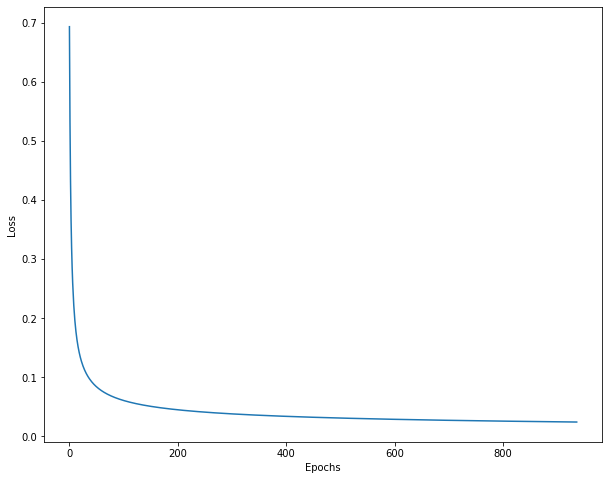

In [22]:
plt.figure(figsize=(10, 8))
plt.plot(errors)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Test model

In [23]:
def classification_accuracy(X: np.ndarray, y: np.ndarray, theta: np.ndarray, threshold:float=0.5) -> np.ndarray:
    """Returns the predicted class of the given dataset
    :param X: an (m, n) ndarray; each row is a (bias + digit pixels)
    :param y: ground truth
    :param theta: a (n, 1) vector of weights
    :param threshold: the threshold against wihch the conditional 
    probabilities are compared. If conditional probability is greater than 
    :param threshold:, then the predicted class is 1 otherwise 0.
    :return: the percentage of correctly classified cases.
    """
    y_hat = model(X, theta)
    assert y.shape == y_hat.shape
    y_predicted = y_hat >= threshold
    return (y_predicted == y).sum() / X.shape[0]

In [24]:
train_accuracy = classification_accuracy(X_train_2digits, y_train_2digits, theta)
print(f'Train accuracy: {train_accuracy * 100}%')

Train accuracy: 99.32774504108225%


In [25]:
test_accuracy = classification_accuracy(X_test_2digits, y_test_2digits, theta)
print(f'Test accuracy: {test_accuracy * 100}%')

Test accuracy: 99.23780487804879%


In [26]:
# cod pentru calcul si afisare matrice de confuzie
from IPython.display import display, HTML

def compute_confusion_matrix(X: np.ndarray, y: np.ndarray, theta: np.ndarray, threshold: float=0.5) -> pd.DataFrame:
    """Returns the confusion matrix of a given dataset.
    :param X: an (m, n) ndarray; each row is a (bias + digit pixels)
    :param y: ground truth
    :param theta: a (n, 1) vector of weights
    :param threshold: the threshold against which the conditional 
    probabilities are compared. If conditional probability is greater than 
    :param threshold:, then the predicted class is 1 otherwise 0.
    :return: the confusion matrix as a pandas DataFrame.
    """
    conf_mat = np.zeros((2, 2))
    y_hat = model(X, theta)
    y_predicted = y_hat >= threshold
    conf_mat[0][0] = np.logical_and(y_predicted == y, y == 0).sum()
    conf_mat[1][1] = np.logical_and(y_predicted == y, y == 1).sum()
    conf_mat[0][1] = np.logical_and(y_predicted != y, y == 1).sum()
    conf_mat[1][0] = np.logical_and(y_predicted != y, y == 0).sum()
    df_conf_mat = pd.DataFrame(conf_mat, dtype=int)
    df_conf_mat.columns = ['Actual class: ' + str(digit1), 'Actual class: ' + str(digit2)]
    df_conf_mat.index = ['Predicted class: ' + str(digit1), 'Predicted class: ' + str(digit2)]
    return df_conf_mat

conf_mat = compute_confusion_matrix(X_test_2digits, y_test_2digits, theta)
display(HTML('<h3>Matricea de confuzie pentru setul de testare:</h3>'))
display(HTML(conf_mat.to_html()))

,Actual class: 3,Actual class: 6
Predicted class: 3,949,6
Predicted class: 6,9,1004
